# Chatbot Evaluation #

In [97]:
#General imports
import numpy as np
import pandas as pd
import time
from importlib import reload
import evaltools
reload(evaltools)
from sqltr import SQLTestRun
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns


In [81]:
# pip install matplotlib

In [83]:
# pip install seaborn

In [68]:
#read input test file:
init_df = pd.read_csv('./data/custom_db_exp.csv')
init_df

,is_sql,text_query,expected_sql
0,1,Show all invoices that were made during Christ...,SELECT * FROM invoice WHERE (TO_CHAR(invoice_d...
1,1,Find the top 3 artists by total albums,"SELECT AR.name, COUNT(AR.name) as TotalAlbums ..."
2,1,list classic composers and their corresponding...,"SELECT T.composer, AVG(T.milliseconds) from tr..."
3,1,list all the countries our customers are from,SELECT distinct country from customer
4,1,What is the total invoice amount by country?,"SELECT billing_country, SUM(total) from invoic..."
5,1,What playlists are there?,SELECT name from playlist
6,1,Who reports to Andrew Adams,"SELECT CONCAT(first_name, ' ', last_name) AS n..."
7,1,List all the tracks under each playlist,"SELECT P.name as playlistName, T.name as track..."
8,1,How many staff does the store have?,SELECT COUNT(*) from employee
9,0,Are we ready?,NaN


In [74]:
#setup parameters

methods = ["rag", "tag"]
# providers = ["OpenAI", "Claude"] #For Claude I am getting this error: Error in query synthesis: Error code: 401 - {'type': 'error', 'error': {'type': 'authentication_error', 'message': 'invalid x-api-key'}}
providers = ["OpenAI"]
temperatures = [0.1, 0.3, 0.5]


combinations = [
    {"method": method, "provider": provider, "temperature": temperature}
    for method, provider, temperature in product(methods, providers, temperatures)
]

In [75]:
combinations

[{'method': 'rag', 'provider': 'OpenAI', 'temperature': 0.1},
 {'method': 'rag', 'provider': 'OpenAI', 'temperature': 0.3},
 {'method': 'rag', 'provider': 'OpenAI', 'temperature': 0.5},
 {'method': 'tag', 'provider': 'OpenAI', 'temperature': 0.1},
 {'method': 'tag', 'provider': 'OpenAI', 'temperature': 0.3},
 {'method': 'tag', 'provider': 'OpenAI', 'temperature': 0.5}]

### Section 1: Initial Query Evaluation ###

In this section we evaluate: 

    1. Latency of query generation. 
    2. Whether the generation result are of right type SQL or error message depending on if text query can be translated into SQL    
    3. If text query can be translated into SQL, is the SQL valid, how many syntax issue according to SQL lint?

In [76]:
# col_names = ["method", "provider", "temperature", "text_query", "expected_sql", 
#              "expected_is_query", "generated_sql", "generated_is_sql", "is_type_corrrect",
#              "generation_latency", "isValidSQL", "numFormatIssues"]

# eval_df = pd.DataFrame(columns=col_names)
df_rows = []

for combination in combinations:
    method = combination["method"]
    provider = combination["provider"]
    temperature = combination["temperature"]
    
    for i in range(len(init_df)):
        text_query = init_df.iloc[i]['text_query']
        expected_sql = init_df.iloc[i]['expected_sql']
        expected_is_query = (init_df.iloc[i]['is_sql'] == 1)

        if(method == "rag"):
            start_time = time.perf_counter()
            generated_sql = evaltools.gen_rag_query(text_query, provider, temperature)
            end_time = time.perf_counter()
        else:
            start_time = time.perf_counter()
            generated_sql = await evaltools.gen_tag_query(text_query, provider, temperature)
            end_time = time.perf_counter()
            
        generation_latency = (end_time - start_time)*1000 # convert seconds to milli seconds
        generated_is_sql = evaltools.is_sql_check(generated_sql)
        is_type_corrrect = evaltools.confirm_type(generated_sql, expected_is_query)
        if(generated_is_sql):
            lintEval = evaltools.check_sql_errors(generated_sql)
            isValidSQL = (lintEval["status"] == "valid")
            numFormatIssues = lintEval["numIssues"]
        else: 
            isValidSQL = "N/A"
            numFormatIssues = "N/A"

        new_row = {
            "method": method, "provider": provider, "temperature": temperature,
            "text_query": text_query, "expected_sql": expected_sql, "expected_is_query": expected_is_query,
            "generated_sql": generated_sql, "generated_is_sql": generated_is_sql, "is_type_corrrect": is_type_corrrect,
            "generation_latency": generation_latency, "isValidSQL": isValidSQL, "numFormatIssues": numFormatIssues
        }
        # Append the row
        df_rows.append(new_row)
        

eval_df = pd.DataFrame(df_rows)


In [99]:
result = await evaltools.gen_tag_query("Find the top 3 artists by total albums", "Claude", 0.1)

Error in query synthesis: Error code: 401 - {'type': 'error', 'error': {'type': 'authentication_error', 'message': 'invalid x-api-key'}}


In [77]:
eval_df.head()

,method,provider,temperature,text_query,expected_sql,expected_is_query,generated_sql,generated_is_sql,is_type_corrrect,generation_latency,isValidSQL,numFormatIssues
0,rag,OpenAI,0.1,Show all invoices that were made during Christ...,SELECT * FROM invoice WHERE (TO_CHAR(invoice_d...,True,SELECT * FROM invoice\nWHERE invoice_date IN (...,True,True,3222.730624,False,N/A
1,rag,OpenAI,0.1,Find the top 3 artists by total albums,"SELECT AR.name, COUNT(AR.name) as TotalAlbums ...",True,"SELECT artist.name, COUNT(album.album_id) AS t...",True,True,3864.214028,False,N/A
2,rag,OpenAI,0.1,list classic composers and their corresponding...,"SELECT T.composer, AVG(T.milliseconds) from tr...",True,"SELECT composer, AVG(milliseconds) as average_...",True,True,2155.009915,False,N/A
3,rag,OpenAI,0.1,list all the countries our customers are from,SELECT distinct country from customer,True,SELECT DISTINCT country FROM customer;,True,True,1047.505163,False,N/A
4,rag,OpenAI,0.1,What is the total invoice amount by country?,"SELECT billing_country, SUM(total) from invoic...",True,"SELECT billing_country, SUM(total) as total_in...",True,True,11922.924619,False,N/A


In [ ]:
#rag generated query seem to have \n line break in their results, I need to handle that. 
eval_df.iloc[0]['generated_sql']


"SELECT * FROM invoice\nWHERE invoice_date IN ('2021-12-24', '2021-12-25', '2021-12-26', '2021-12-31', '2022-01-01');"

Text(0.5, 0.98, 'Generation Latency by Method, Provider, and Temperature')

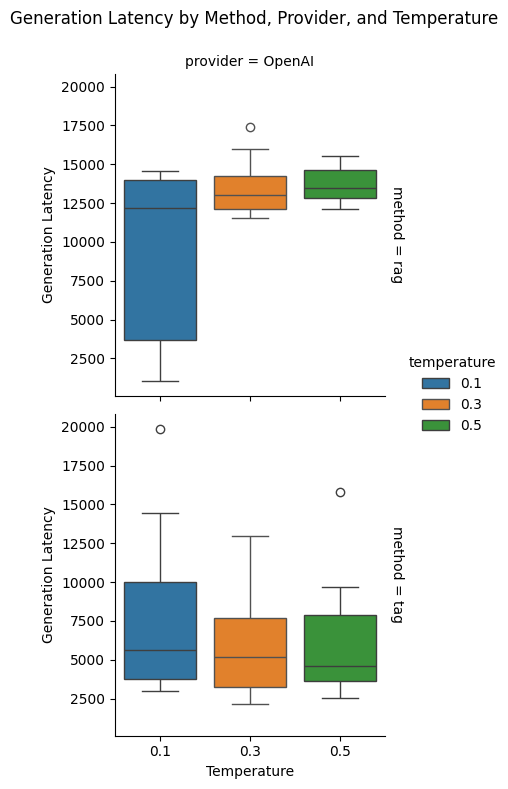

In [93]:
# Facet Grid for Combined Analysis
g = sns.FacetGrid(eval_df, row="method", col="provider", hue="temperature", margin_titles=True, height=4)
g.map(sns.boxplot, "temperature", "generation_latency", order=[0.1, 0.3, 0.5])
g.add_legend()
g.set_axis_labels("Temperature", "Generation Latency")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("Generation Latency by Method, Provider, and Temperature")

In [94]:
eval_df.to_csv("eval_df_init.csv")

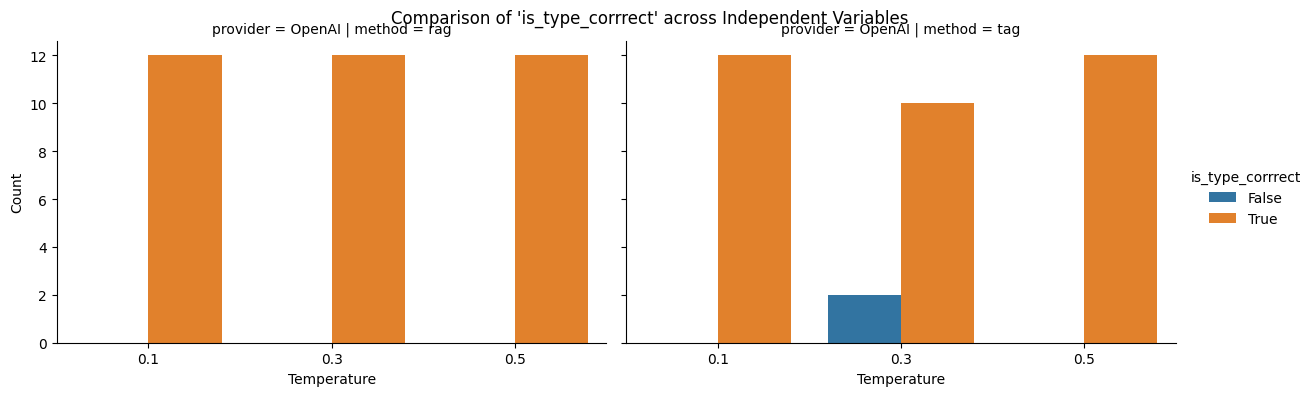

In [95]:
g = sns.catplot(
    data=eval_df,
    x="temperature",
    hue="is_type_corrrect",
    col="method",
    row="provider",
    kind="count",
    height=4,
    aspect=1.5
)

# Add titles and labels
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("Comparison of 'is_type_corrrect' across Independent Variables")
g.set_axis_labels("Temperature", "Count")

In [23]:
expected_call_db_result

,invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total
0,1,2,2021-01-01,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98
1,83,42,2021-12-26,"9, Place Louis Barthou",Bordeaux,None,France,33000,0.99
2,166,12,2022-12-25,"Praça Pio X, 119",Rio de Janeiro,RJ,Brazil,20040-020,13.86
3,248,40,2023-12-24,"8, Rue Hanovre",Paris,None,France,75002,5.94
4,250,55,2024-01-01,421 Bourke Street,Sidney,NSW,Australia,2010,13.86


In [24]:
rag_call_db_result

,invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total


In [25]:
tag_call_db_result

,invoice_id,customer_id,invoice_date,total
0,166,12,2022-12-25,13.86


Using existing vector store
Loading existing vectors from database...
selectinvoice_id,customer_id,invoice_date,totalfrominvoicewhereinvoice_date::datein('2022-12-24','2022-12-25','2022-12-26','2022-12-31','2023-01-01')orderbyinvoice_date;
select*frominvoicewhereinvoice_datein('2024-12-24','2024-12-25','2024-12-26','2024-12-31','2025-01-01');
select*frominvoicewhere(to_char(invoice_date,'mm-dd')in('12-24','12-25','12-26','12-31','01-01'));


   invoice_id  customer_id invoice_date  total
0         166           12   2022-12-25  13.86
   invoice_id  customer_id invoice_date          billing_address billing_city  \
0           1            2   2021-01-01  Theodor-Heuss-Straße 34    Stuttgart   

  billing_state billing_country billing_postal_code total  
0          None         Germany               70174  1.98  
Empty DataFrame
Columns: [invoice_id, customer_id, invoice_date, billing_address, billing_city, billing_state, billing_country, billing_postal_code, total]
Index: []
   invoice_

,sql_complexity,sql_complexity_description,sql_prompt,sql,exp_gen_similarity_tag,exp_gen_len_diff_tag,is_exp_gen_resp_equal_tag,gen_sql_tag,latency_tag,lint_result_rag,exp_gen_similarity_rag,exp_gen_len_diff_rag,is_exp_gen_resp_equal_rag,gen_sql_rag,latency_rag
0,basic SQL,basic SQL with a simple select statement,Show all invoices that were made during Christ...,SELECT * FROM invoice WHERE (TO_CHAR(invoice_d...,0.591760,71.0,False,"SELECT invoice_id, customer_id, invoice_date, ...",13277.225768,- Query produces an unknown number of result c...,0.782178,6.0,False,SELECT * FROM invoice\nWHERE invoice_date IN (...,3438.012525
1,single join,"only one join (specify inner, outer, cross)",Find the top 3 artists by total albums,"SELECT AR.name, COUNT(AR.name) as TotalAlbums ...",0.819113,15.0,False,"SELECT artist.name, COUNT(album.album_id) AS t...",6758.888496,- Query produces an unknown number of result c...,0.819113,15.0,False,"SELECT artist.name, COUNT(album.album_id) AS t...",2573.554219
